In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

# Demographics

In [2]:
import pandas
import os

# This query represents dataset "All wearable" for domain "person" and was generated for All of Us Registered Tier Dataset v7
dataset_93542101_person_sql = """
    SELECT
        person.person_id,
        person.gender_concept_id,
        p_gender_concept.concept_name as gender,
        person.birth_datetime as date_of_birth,
        person.race_concept_id,
        p_race_concept.concept_name as race,
        person.ethnicity_concept_id,
        p_ethnicity_concept.concept_name as ethnicity,
        person.sex_at_birth_concept_id,
        p_sex_at_birth_concept.concept_name as sex_at_birth 
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.person` person 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_gender_concept 
            ON person.gender_concept_id = p_gender_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_race_concept 
            ON person.race_concept_id = p_race_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_ethnicity_concept 
            ON person.ethnicity_concept_id = p_ethnicity_concept.concept_id 
    LEFT JOIN
        `""" + os.environ["WORKSPACE_CDR"] + """.concept` p_sex_at_birth_concept 
            ON person.sex_at_birth_concept_id = p_sex_at_birth_concept.concept_id"""

dataset_93542101_person_df = pandas.read_gbq(
    dataset_93542101_person_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

Downloading:   0%|          | 0/410361 [00:00<?, ?rows/s]

In [3]:
from datetime import datetime

reference_time = pandas.Timestamp('2019')
dataset_93542101_person_df['age'] = (reference_time - pandas.to_datetime(dataset_93542101_person_df['date_of_birth'].dt.date)).dt.days / 365.25

bins = [0, 29, 39, 49, 59, 69, float('inf')]
overall_bins = ["<29", "30-39", "40-49", "50-59", "60-69", ">70"]
labels = ["<29", "30-39", "40-49", "50-59", "60-69", ">70"]

dataset_93542101_person_df['age_bins'] = pandas.cut(dataset_93542101_person_df['age'], bins=bins, labels=labels, right=False)


# Original race codings
all_of_us_common_race_label_mapping = {
    'PMI: Skip': 'Mixed/Others/Undeclared',
    'None of these': 'Mixed/Others/Undeclared',
    'I prefer not to answer': 'Mixed/Others/Undeclared',
    'More than one population': 'Mixed/Others/Undeclared',
    'Another single population': 'Mixed/Others/Undeclared',
    'None Indicated': 'Mixed/Others/Undeclared',
    'White': 'Caucasian, European, White',
    'Black or African American': 'Black or African-American',
    'Asian': 'Asian',
}

dataset_93542101_person_df['race_mapped'] = dataset_93542101_person_df['race'].map(all_of_us_common_race_label_mapping)
dataset_93542101_person_df['age_bins_contin'] = dataset_93542101_person_df['age_bins'].map(dict(zip(overall_bins, np.arange(len(overall_bins)))))
dataset_93542101_person_df['sex'] =  dataset_93542101_person_df['sex_at_birth'].map({'Male': 'male', 'Female':'female', 'Not male, not female, prefer not to answer, or skipped':'other', 'No matching concept':np.nan})

# Minute of day steps

In [4]:
import pandas
import os

# This query represents dataset "FitBit all Data" for domain "fitbit_intraday_steps" and was generated for All of Us Registered Tier Dataset v4
steps_minute_of_day_sql = """
    SELECT
        (EXTRACT(HOUR FROM CAST(steps_intraday.datetime AS DATETIME)) * 60) + EXTRACT(MINUTE FROM CAST(steps_intraday.datetime AS DATETIME)) AS minute_of_day,
        steps_intraday.PERSON_ID,
        AVG(STEPS) avg_steps 
        
    from
        `""" + os.environ["WORKSPACE_CDR"] + """.steps_intraday` steps_intraday   
    WHERE
        steps_intraday.PERSON_ID IN (
            SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_fitbit = 1 
                ) 
            ) 
        GROUP BY
            person_id,
            minute_of_day"""

fitbit_steps_minute_level = pandas.read_gbq(
    steps_minute_of_day_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")


Downloading:   0%|          | 0/22343041 [00:00<?, ?rows/s]

In [5]:
lower_bound = 0
upper_bound = 30

fitbit_steps_minute_level = fitbit_steps_minute_level[fitbit_steps_minute_level['avg_steps'].between(lower_bound, upper_bound)]

all_of_us_steps_minute_of_day = fitbit_steps_minute_level.pivot(index='minute_of_day', columns='PERSON_ID', values='avg_steps')
all_of_us_steps_minute_of_day = all_of_us_steps_minute_of_day.astype(float)

# Minute of day heart rate

In [6]:
import pandas
import os

# This query represents dataset "FitBit all Data" for domain "fitbit_heart_rate_level" and was generated for All of Us Registered Tier Dataset v4
heart_rate_minute_of_day_sql = """
    SELECT
        (EXTRACT(HOUR FROM CAST(heart_rate_minute_level.datetime AS DATETIME)) * 60) + EXTRACT(MINUTE FROM CAST(heart_rate_minute_level.datetime AS DATETIME)) AS minute_of_day,
        heart_rate_minute_level.PERSON_ID,
        AVG(heart_rate_value) avg_rate 
    from
        `""" + os.environ["WORKSPACE_CDR"] + """.heart_rate_minute_level` heart_rate_minute_level   
    WHERE
        heart_rate_minute_level.PERSON_ID IN (
            SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` p 
                    WHERE
                        has_fitbit = 1 
                ) 
            ) 
        GROUP BY
            person_id,
            minute_of_day"""

fitbit_hr_minute_level = pandas.read_gbq(
    heart_rate_minute_of_day_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")

Downloading:   0%|          | 0/20283131 [00:00<?, ?rows/s]

In [7]:
hr_groupby_mean_minute_of_day = fitbit_hr_minute_level[['minute_of_day', 'avg_rate']].groupby('minute_of_day').mean()
hr_groupby_count_minute_of_day = fitbit_hr_minute_level[['minute_of_day', 'avg_rate']].groupby('minute_of_day').count()

all_of_us_heartrate_minute_of_day = fitbit_hr_minute_level.pivot(index='minute_of_day', columns='PERSON_ID', values='avg_rate')

# Resting Heart Rate Calculation

In [ ]:
import pandas
import os

night_average_heart_rate_fitbit_sql ="""
SELECT
    hr.date,
    hr.PERSON_ID,
    AVG(hr.minute_heart_rate) AS avg_heart_rate
FROM (
    SELECT
        FORMAT_TIMESTAMP("%Y-%m-%d %H:%M", heart_rate_minute_level.datetime) as datetime,
        heart_rate_minute_level.person_id as person_id,
        CAST(heart_rate_minute_level.heart_rate_value AS FLOAT64) as minute_heart_rate,
        CAST(heart_rate_minute_level.datetime as DATE) as date,
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.heart_rate_minute_level` heart_rate_minute_level  
    WHERE
        heart_rate_minute_level.person_id IN (
            SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                    WHERE
                        has_fitbit = 1 
                )
        ) 
        AND EXTRACT(HOUR FROM heart_rate_minute_level.datetime) < 7
    ) hr
JOIN (
    SELECT
        FORMAT_TIMESTAMP("%Y-%m-%d %H:%M", steps_intraday.datetime) as datetime,
        steps_intraday.person_id as person_id,
        CAST(steps_intraday.steps AS INT64) as minute_steps,
        CAST(steps_intraday.datetime as DATE) as date,
    FROM
        `""" + os.environ["WORKSPACE_CDR"] + """.steps_intraday` steps_intraday   
    WHERE
        steps_intraday.PERSON_ID IN (
            SELECT
                distinct person_id  
            FROM
                `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
            WHERE
                cb_search_person.person_id IN (
                    SELECT
                        person_id 
                    FROM
                        `""" + os.environ["WORKSPACE_CDR"] + """.cb_search_person` cb_search_person  
                    WHERE
                        has_fitbit = 1 
                ) 
        )
        AND EXTRACT(HOUR FROM steps_intraday.datetime) < 7
    ) steps
ON hr.person_id = steps.PERSON_ID AND hr.datetime = steps.datetime
WHERE steps.minute_steps = 0
GROUP BY
    hr.PERSON_ID,
    hr.date"""

night_average_heart_rate_fitbit_df = pandas.read_gbq(
    night_average_heart_rate_fitbit_sql,
    dialect="standard",
    use_bqstorage_api=("BIGQUERY_STORAGE_API_ENABLED" in os.environ),
    progress_bar_type="tqdm_notebook")


In [11]:
night_average_heart_rate_fitbit_df['date'] = pd.to_datetime(night_average_heart_rate_fitbit_df['date'])


In [40]:
def clean_daily_data(df, columns, pid_name, date_name):
    """
    df: the dataframe with samples
    columns: should be a dictionary, with the columns to filter and the filter values, i.e. {'resting_heart_rate': (20,200)}
    pid_name: name of the pid column
    date_name: name of the date column, assumed not to already be datetime based
    """

    df['pid'] = df[pid_name]
    # Make sure dates are in pandas datetime
    df['date'] = pd.to_datetime(df[date_name])
    
    # Set a multi-index on PID and date
    df = df.set_index(['pid', 'date']).sort_index()

    # Iterate through the set of columns to filter on
    for key, values in columns.items():
        df = df[df[key].between(values[0], values[1])]
        
    # Resample to daily, important for lagged-z-scoring
    df = df.groupby('pid').apply(lambda x: x.droplevel(0).resample('D').asfreq())

    df['day_of_week'] = df.index.get_level_values(1).dayofweek
    
    return df

    

In [ ]:
columns = {
    'avg_heart_rate': (20, 200),

}

night_average_heart_rate_fitbit_df = clean_daily_data(night_average_heart_rate_fitbit_df, columns, 'PERSON_ID', 'date')


In [42]:
aou_mean_heart_rate = night_average_heart_rate_fitbit_df.groupby('PERSON_ID').mean().merge(dataset_93542101_person_df, left_index = True, right_on = 'person_id')
aou_mean_heart_rate = aou_mean_heart_rate.rename(columns = {'avg_heart_rate': 'heart_rate'})
aou_mean_heart_rate['age_bins_contin'] = aou_mean_heart_rate['age_bins_contin'].astype(int)
aou_mean_heart_rate['dataset'] = 'all_of_us'

In [43]:
all_cols = ['age', 'sex', 'race_mapped', 'heart_rate', 'person_id']
aou_pids = aou_mean_heart_rate[all_cols].dropna()

# Multiple regression

In [44]:
all_cols = ['age', 'sex', 'race_mapped', 'heart_rate']

md = smf.ols("heart_rate ~ age + sex + C(race_mapped, Treatment(reference='Caucasian, European, White'))", aou_mean_heart_rate[all_cols].dropna())
mdf = md.fit()
mdf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             heart_rate   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     293.1
Date:                Mon, 05 Feb 2024   Prob (F-statistic):               0.00
Time:                        19:23:59   Log-Likelihood:                -49774.
No. Observations:               13735   AIC:                         9.956e+04
Df Residuals:                   13728   BIC:                         9.961e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================
                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                         75.1629      0.268    280.029      0.000      74.637      75.689
sex[T.male]                                                                                       -4.6949      0.173    -27.210      0.000      -5.033      -4.357
sex[T.other]                                                                                      -0.0679      1.217     -0.056      0.955      -2.454       2.318
C(race_mapped, Treatment(reference='Caucasian, European, White'))[T.Asian]                        -0.6845      0.447     -1.531      0.126      -1.561       0.192
C(race_mapped, Treatment(reference='Caucasian, European, White'))[T.Black or African-American]     5.4947      0.351     15.638      0.000       4.806       6.183
C(race_mapped, Treatment(reference='Caucasian, European, White'))[T.Mixed/Others/Undeclared]       1.5015      0.281      5.344      0.000       0.951       2.052
age                                                                                               -0.1083      0.005    -21.448      0.000      -0.118      -0.098
==============================================================================
Omnibus:                      404.422   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              444.242
Skew:                           0.418   Prob(JB):                     3.42e-97
Kurtosis:                       3.278   Cond. No.                         826.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Minute of day means

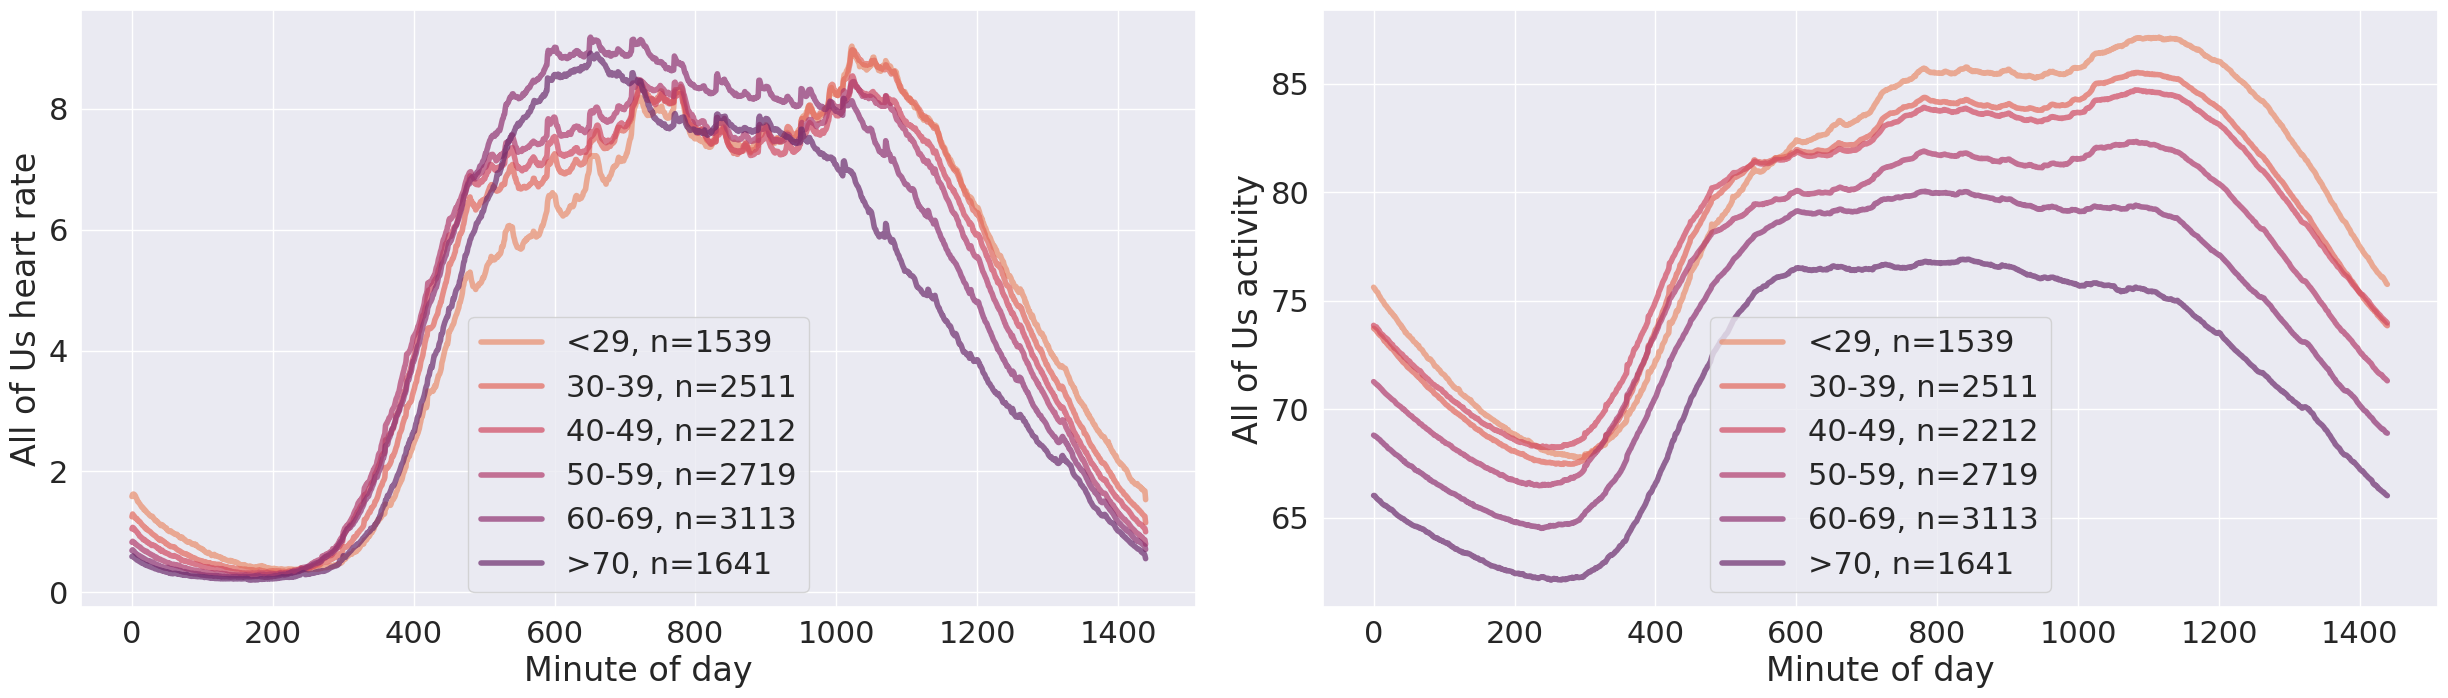

In [52]:
overall_bins = ["<29", "30-39", "40-49", "50-59", "60-69", ">70"]
sns.set_theme(font_scale = 2)

# We'll have the palette be "flare" for each
sns.set_palette("flare", n_colors = len(overall_bins))

fig, axes = plt.subplots(1, 2, figsize = (25, 7.5))
pids_holder = []
# Top right: steps, un-normalized, All of Us
# Iterate through the age bins and plot the color based on the age
for pid_num, age_bin in enumerate(overall_bins):
    pids_here = list(set(dataset_93542101_person_df[dataset_93542101_person_df['age_bins'] == age_bin]['person_id']).intersection(all_of_us_steps_minute_of_day.columns).intersection(all_of_us_heartrate_minute_of_day.columns).intersection(aou_pids['person_id'].values))
    pids_holder.append(len(pids_here))
    all_of_us_steps_minute_of_day[pids_here].mean(axis = 1).plot(linewidth = 4, ax = axes[0], alpha = 0.7, label = f'{age_bin}, n={len(pids_here)}')
    all_of_us_heartrate_minute_of_day[pids_here].mean(axis = 1).plot(linewidth = 4, ax = axes[1], alpha = 0.7, label = f'{age_bin}, n={len(pids_here)}')

    
axes[0].legend()
axes[1].legend()

axes[0].set(xlabel = "Minute of day", ylabel = 'All of Us heart rate')
axes[1].set(xlabel = "Minute of day", ylabel = 'All of Us activity')

fig.tight_layout()
plt.show()

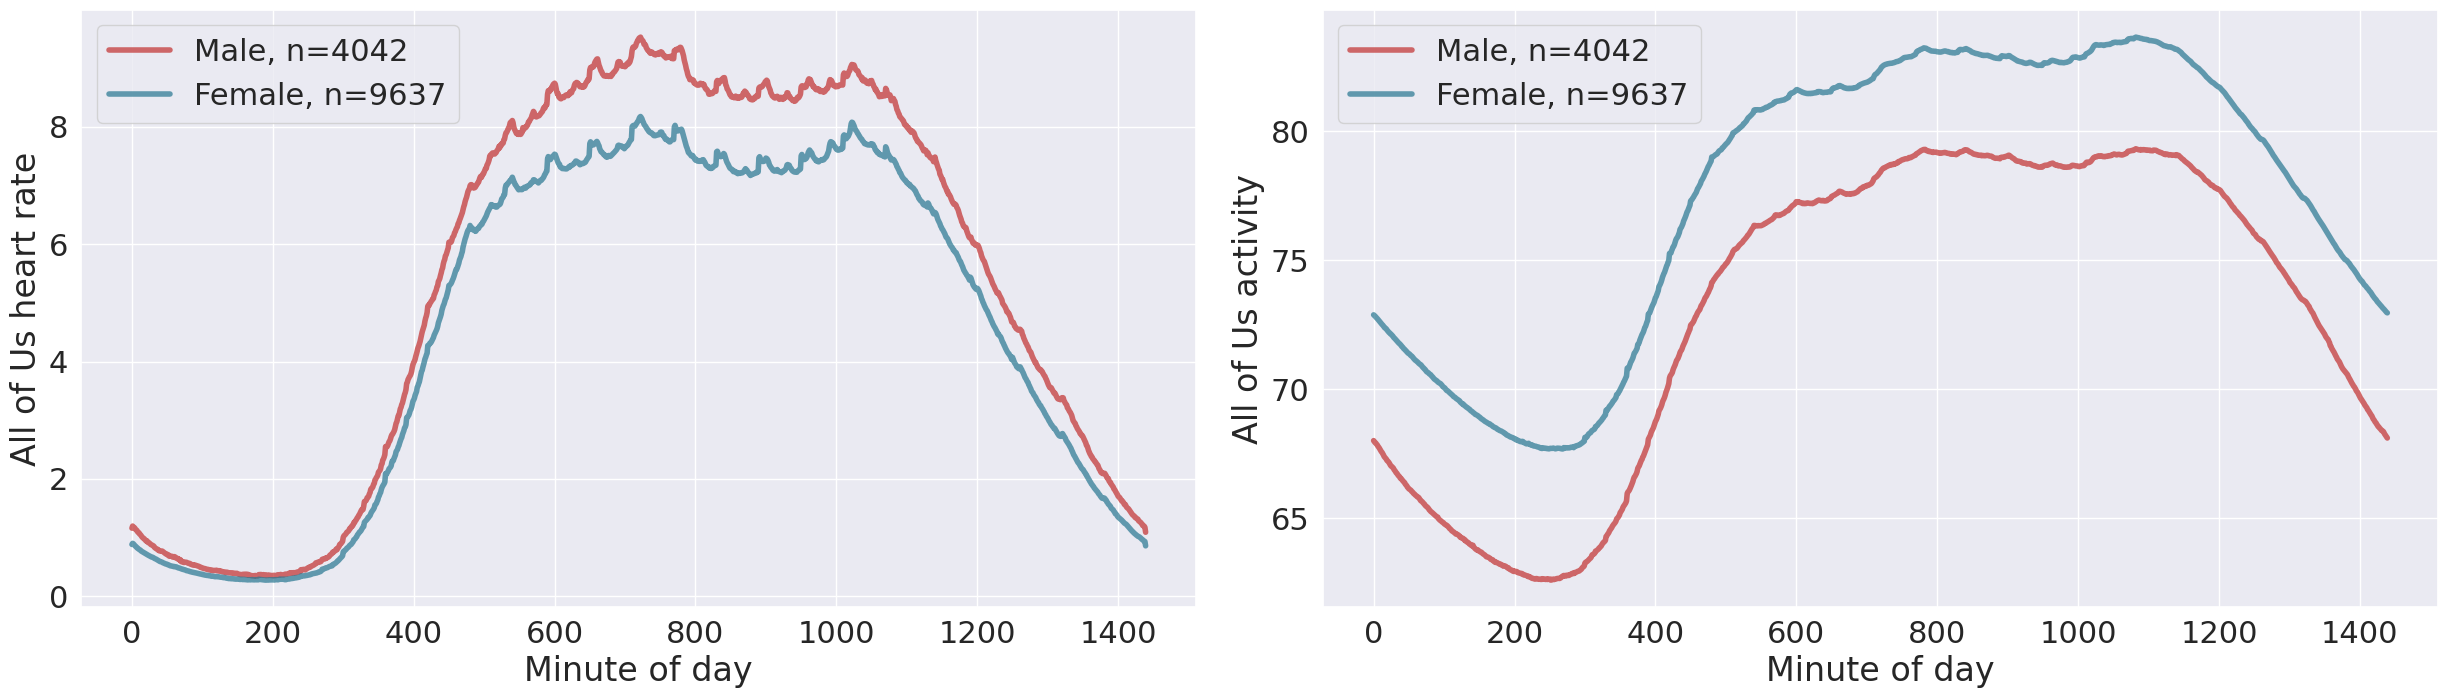

In [53]:
#overall_bins = ["<29", "30-39", "40-49", "50-59", "60-69", ">70"]

overall_genders = ['male', 'female']
sns.set_theme(font_scale = 2)

# We'll have the palette be "flare" for each
idle_hours_red = '#c12e2d'
idle_hours_blue = '#267690'
sns.set_palette([idle_hours_red, idle_hours_blue], n_colors = len(overall_genders))

fig, axes = plt.subplots(1, 2, figsize = (25, 7.5))
pids_holder = []
# Top right: steps, un-normalized, All of Us
# Iterate through the age bins and plot the color based on the age
for pid_num, sex in enumerate(overall_genders):
    
    pids_here = list(set(dataset_93542101_person_df[dataset_93542101_person_df['sex'] == sex]['person_id']).intersection(all_of_us_steps_minute_of_day.columns).intersection(all_of_us_heartrate_minute_of_day.columns).intersection(aou_pids['person_id'].values))
    pids_holder.append(len(pids_here))
    all_of_us_steps_minute_of_day[pids_here].mean(axis = 1).plot(linewidth = 4, ax = axes[0], alpha = 0.7, label = f'{sex.capitalize()}, n={len(pids_here)}')
    all_of_us_heartrate_minute_of_day[pids_here].mean(axis = 1).plot(linewidth = 4, ax = axes[1], alpha = 0.7, label = f'{sex.capitalize()}, n={len(pids_here)}')
    
axes[0].legend()
axes[1].legend()

axes[0].set(xlabel = "Minute of day", ylabel = 'All of Us heart rate')
axes[1].set(xlabel = "Minute of day", ylabel = 'All of Us activity')

fig.tight_layout()
plt.show()

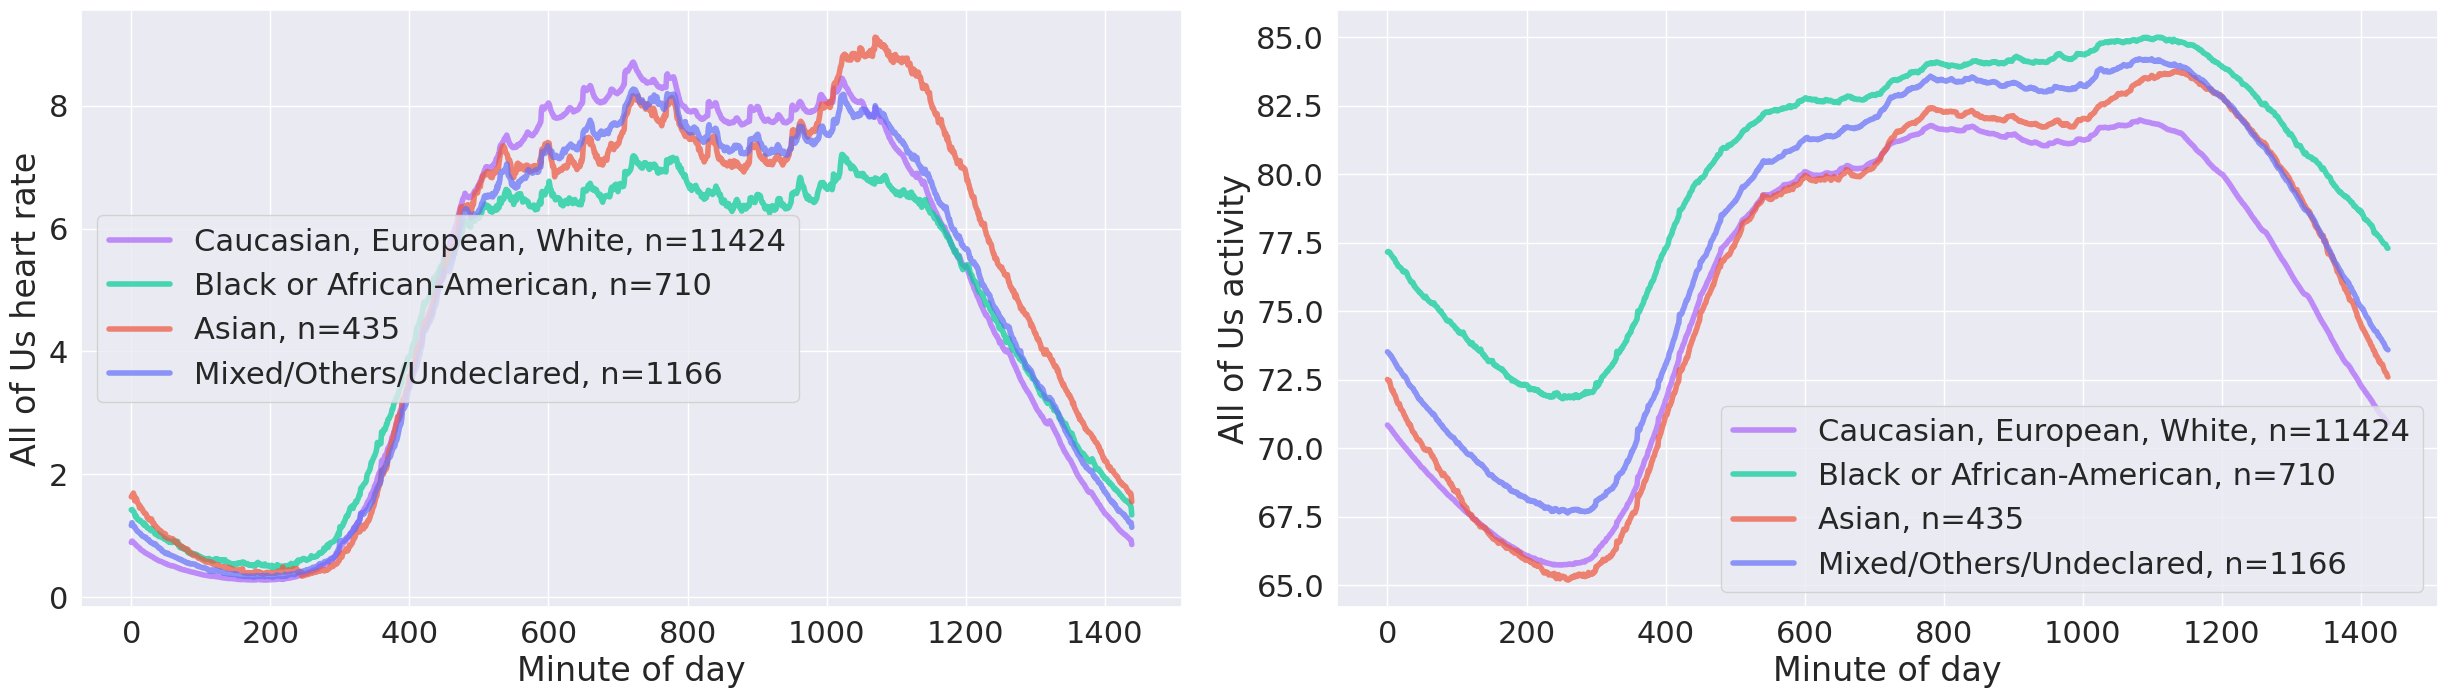

In [54]:
common_race_labels = [
    'Caucasian, European, White',
    'Black or African-American',
    'Asian',
    'Mixed/Others/Undeclared',
]

ethnicity_colors = ['#ab63fa', '#00cc96', '#ef553b', '#636efa']
sns.set_theme(font_scale = 2)

fig, axes = plt.subplots(1, 2, figsize = (25, 7.5))
pids_holder = []
# Top right: steps, un-normalized, All of Us
# Iterate through the age bins and plot the color based on the age
for pid_num, ethnicity in enumerate(common_race_labels):
    pids_holder.append(len(pids_here))
    pids_here = list(set(dataset_93542101_person_df[dataset_93542101_person_df['race_mapped'] == ethnicity]['person_id']).intersection(all_of_us_steps_minute_of_day.columns).intersection(all_of_us_heartrate_minute_of_day.columns).intersection(aou_pids['person_id'].values))
    all_of_us_steps_minute_of_day[pids_here].mean(axis = 1).plot(linewidth = 4, ax = axes[0], alpha = 0.7, label = f'{ethnicity}, n={len(pids_here)}', color = ethnicity_colors[pid_num])
    all_of_us_heartrate_minute_of_day[pids_here].mean(axis = 1).plot(linewidth = 4, ax = axes[1], alpha = 0.7, label = f'{ethnicity}, n={len(pids_here)}', color = ethnicity_colors[pid_num])
    
axes[0].legend()
axes[1].legend()

axes[0].set(xlabel = "Minute of day", ylabel = 'All of Us heart rate')
axes[1].set(xlabel = "Minute of day", ylabel = 'All of Us activity')

fig.tight_layout()
plt.show()

In [55]:
def z_score_modalities(df, modalities, length, min_num, offset, pid_name):
    """
    Inputs:
    df: a pandas dataframe, multi-indexed by pid and date
    modalities: iterable of strings, should be the names of columns
    length: the length of the window to z-score by
    min_num: the minumum number of non-missing days in the baseline period
    offset: how many days lagged to start the baseline period
    pid_name: the name of the index level with the pids
    """
    
    grouped_mean = df.groupby(pid_name)[modalities].rolling(window = length, min_periods = min_num).mean().shift(offset)
    grouped_std = df.groupby(pid_name)[modalities].rolling(window = length, min_periods = min_num).std().shift(offset)

    z_modality_names = [mod + "_z" for mod in modalities]
    df[z_modality_names] = (df[modalities].values - grouped_mean.values)/grouped_std.values
    return df

In [56]:
all_of_us_nightly_z = z_score_modalities(night_average_heart_rate_fitbit_df, ['avg_heart_rate'], 10, 6, 12, 'pid')

In [57]:
def get_iso_format_means(df, iso_feature, short_year_wrap, wrap_week):
    df_iso = df.reset_index().copy()[[iso_feature, 'date']].dropna()
    df_iso[['year', 'week', 'day']] = df_iso['date'].dt.isocalendar()
    df_iso['year'] = 2020
    if short_year_wrap:
        df_iso.loc[df_iso[df_iso['week'] > wrap_week].index, 'year'] = 2019
    
    df_iso['date'] = df_iso['year'].astype(str) + '-' + df_iso['week'].apply(lambda x: f"{x:02}") + '-' + df_iso['day'].astype(str)
    df_iso_groupby_mean = df_iso.groupby('date')[iso_feature].mean()
    df_iso_groupby_mean.index = pd.to_datetime(df_iso_groupby_mean.reset_index()['date'], format = '%G-%V-%u')
    return df_iso_groupby_mean

In [58]:
all_of_us_nightly_z_iso = get_iso_format_means(all_of_us_nightly_z, 'avg_heart_rate_z', False, _)

In [20]:
all_of_us_nightly_z_iso.to_csv('all_of_us_nightly_z_iso.csv')